In [1]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=3fd53a4400e3af453317db3f6c08370a0357cf6c4c1b66c7746d20d63d0af195
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
!pip install tokenizers

     |████████████████████████████████| 3.3MB 18.0MB/s 


In [3]:
!pip install transformers

     |████████████████████████████████| 2.1MB 19.5MB/s 
     |████████████████████████████████| 901kB 41.4MB/s 


In [4]:
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import urllib
import wget

MAX_LEN = 200
EPOCHS = 3
VERBOSE = 2
BATCH_SIZE = 10

In [5]:
DATA_OUT_PATH = './data_out/KOR'

In [6]:
#학습 시각화

def plot_graphs(history, string, string_1, string_2):
  plt.plot(history.history[string])
  plt.plot(history.history[string_1])
  plt.plot(history.history[string_2])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, string_1, string_2])
  plt.show()

In [7]:
#버트사전모델
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", lowercase=False)
save_path = "bert-base-multilingual-cased/"
if not os.path.exists(save_path):
  os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

tokenizer = BertWordPieceTokenizer("bert-base-multilingual-cased/vocab.txt", lowercase=False)

In [8]:
train_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_train.json"
train_path = keras.utils.get_file('train.json', train_data_url)
eval_data_url = "https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url)

3883008/3881058 [==============================] - 0s 0us/step


In [9]:
wget.download('https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-config.json', out='./bert-base-multilingual-cased')
os.rename('./bert-base-multilingual-cased/bert-base-multilingual-cased-config.json', './bert-base-multilingual-cased/config.json')
wget.download("https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-tf_model.h5", out='./bert-base-multilingual-cased/')
os.rename('./bert-base-multilingual-cased/bert-base-multilingual-cased-tf_model.h5', './bert-base-multilingual-cased/tf_model.h5')

In [10]:
#json 데이터 구조에서 모델 입력에 필요한 질문, 본문, 정답을 가져오기 위한 함수

def create_squad_examples(raw_data):
  squad_examples = []
  for item in raw_data["data"]:
    for para in item["paragraphs"]:
      context = para["context"]
      for qa in para["qas"]:
        question = qa["question"]
        answer_text = qa["answers"][0]["text"]
        start_char_idx = qa["answers"][0]["answer_start"]
        squad_eg = SquadExample(
            question, context, start_char_idx, answer_text
        )
        squad_eg.preprocess()
        squad_examples.append(squad_eg)
  return squad_examples

  '''json에서 para["context"]에는 본문이 있으며,
   qa["question"]은 질문이며,
  qa["answers"][0]["text"]는 정답이며,
  qa["answers"][0]["answer_start"]는 본문에서 정답의 위치 포지션을 나타낸다.'''

In [11]:
# 모델에 입력 가능한 학습 데이터로 변경
# SquadExample의 결과값은 정제되지 않은 데이터를 학습할 때 모델에 입력할 수 있게 하는 클래스이다.
class SquadExample:
  # create_squad_examples를 통해 1차 가공한 값들을 __init__함수를 실행해 클래스가 해당 값들을 가지고 있다.

  def __init__(self, question, context, start_char_idx, answer_text):
    self.question = question #질문
    self.context = context#답이 존재하는 본문
    self.start_char_idx = start_char_idx#본문에서 시작 위치
    self.answer_text = answer_text#정답
    self.skip = False #데이터를 사용할지 사용하지 않을지를 결정하는 변수값
                      #False인 경우 데이터 사용 True인 경우 사용하지 않음


  # 문자열 입력에 문제가 없도록 변경하는 작업
  # 입력된 데이터(유니코드형태) 문제를 일으킬 수 있는 다양한 요소가 존재
  # 다양한 문자 형식을 입/출력이 문제가 되지 않는 형태로 만들기 위해 -> 3가지 작업
  """
  (1)문자열로 만들고 
  (2)스페이스 단위로 나누고 
  (3)나눈 값들을 다시 스페이스 단위로 바꿔서 해당 입력에 문제가 일어날 요소를 사전에 정리
  """
  def preprocess(self):
    context = self.context
    question = self.question
    answer_text = self.answer_text
    start_char_idx = self.start_char_idx

    context = " ".join(str(context).split())
    question = " ".join(str(question).split())
    answer = " ".join(str(answer_text).split())

    end_char_idx = start_char_idx + len(answer) #본문에서 시작 위치에서 정답 길이를 더한 값
    if end_char_idx >= len(context):
      self.skip = True
      return
    """True 값이 설정됐다는 것
    "답이 본문 범위에 존재하지 않는다"는 것을 의미
    self.skip이 True가 되는 조건 = end_char_idx가 본문길이를 벗어난 위치인 경우이다.
    end_char_idx 값이 본문을 넘어간다는 것은 답이 본문에 존재하지 않기 때문이며 이러한 데이터는 사용할 수 없다.

    그래서 예외처리!!
    """

    # 먼저, context의 길이만큼 is_char_in_ans의 값을 모두 0으로 만든다.
    # 답이 존재하는 부분은 1로 모두 채운다.
    is_char_in_ans = [0] * len(context)
    for idx in range(start_char_idx, end_char_idx):
      is_char_in_ans[idx] = 1

    # tokenizer.encode 통해 사전의 인덱스 값으로 변환한 값인 tokenized_context를 만든다.
    tokenized_context = tokenizer.encode(context)
    ans_token_idx = []
    """
    offsets함수는 encode함수에 들어간 값이 어떻게 분리 됐는지 offset 값을 다 담고 있다.
    토크나이저에 의해 각 띄어쓰기된 토큰 정보가 분리되기 때문에 시작과 끝에 대한 인덱스 값이 변한다.
    그렇기 때문에 변경된 위치 정보에 맞춰 정답에 위치를 재설정해야 한다.
    
    """

    # 정답 위치로 인식되는 경우 ans_token_idx에 담는다.
    for idx, (start, end) in enumerate(tokenized_context.offsets):
      if sum(is_char_in_ans[start:end]) > 0:
             ans_token_idx.append(idx)
    
    # 답이 존재하지 않으므로 아래 부분 생략
    if len(ans_token_idx) == 0:
      self.skip = True
      return

    # 답이 존재한다면 
    # ans_token_idx[0]은 정답이 시작하는 토근의 인덱스가 되고
    # ans_token_idx[-1]은 정답이 끝나는 인덱스가 된다.
    start_token_idx = ans_token_idx[0]
    end_token_idx = ans_token_idx[-1]

    # 본문과 질문을 연결하는 부분이다.
    tokenized_question = tokenizer.encode(question) # 질문을 인덱스화


    input_ids = tokenized_context.ids + tokenized_question.ids[1:] # 본문 뒤에 붙여 input_ids로 만든다. 
    #버트의 입력 형태인 토큰 타입으로 만드는데 문맥은 0으로 질문으로 만들고 어텐션 마스크 범위를 설정한다.
    token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
        tokenized_question.ids[1:]
    )
    attention_mask = [1] * len(input_ids)


    # 최대 길이만큼 패드 설정
    # 예외처리로 전체 길이가 0 이하이면 self.skip에 True를 지정해 해당 데이터를 사용하지 않는다.
    padding_length = MAX_LEN -len(input_ids)
    if padding_length > 0: #pad
      input_ids = input_ids + ([0] * padding_length)
      attention_mask = attention_mask + ([0] * padding_length)
      token_type_ids = token_type_ids + ([0] * padding_length)
    elif padding_length < 0:
      self.skip = True
      return

    self.input_ids = input_ids
    self.token_type_ids = token_type_ids
    self.attention_mask = attention_mask
    self.start_token_idx = start_token_idx
    self.end_token_idx = end_token_idx
    self.context_token_to_char = tokenized_context.offsets

In [12]:
def create_inputs_targets(squad_examples):
  
  dataset_dict = {
      "input_ids": [],
      "token_type_ids": [],
      "attention_mask": [],
      "start_token_idx":[],
      "end_token_idx": [],
  }
  for item in squad_examples:
    if item.skip == False:                            #skip 값이 True인 것은 제외하는 것을 볼 수 있다.
      for key in dataset_dict:
        dataset_dict[key].append(getattr(item, key)) #aetattr함수를 통해 item 내의 객체 속성값을 가져온다.
  for key in dataset_dict:
    dataset_dict[key] = np.array(dataset_dict[key])


  # dataset_dict의 값 중에서 
  # 입력셋에 필요한 값들은 x
  # 정답셋에 필요한 값들은 y
  x = [
       dataset_dict["input_ids"],
       dataset_dict["token_type_ids"],
       dataset_dict["attention_mask"],
  ]
  y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
  return x, y

In [13]:
with open(train_path) as f:
  raw_train_data = json.load(f)

with open(eval_path) as f:
  raw_eval_data = json.load(f)

train_squad_examples = create_squad_examples(raw_train_data)
x_train, y_train = create_inputs_targets(train_squad_examples) #create_input_target()를 통해 훈련과 평가에 사용될 입력과 정답을 만듬.
print(f"{len(train_squad_examples)} training points created.")


eval_squad_examples = create_squad_examples(raw_eval_data)
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation potints created.")

60407 training points created.
5774 evaluation potints created.


# KorQuAD 1.0 학습 및 테스트

In [14]:
class TFBERTQuestionAnswering(tf.keras.Model):
  # tf.keras.Model
  # 2개의 함수 __init__과 call을 선언


  def __init__(self, model_name, dir_path, num_class):
    super(TFBERTQuestionAnswering, self).__init__()
    self.encoder = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)  # self.encoder는 from_pretrained 함수를 통해 "./bert-base-multilinugual-cased/'에 저장해 둔 모델을 불러온다."
    
    # 기계독해는 정답이 되는 토큰의 시작 위치와 끝 위치를 맞춰야 한다.
    # start_logit와 end_logit을 맞추기 위한 두 개의 Dense층을 선언한다.
    self.start_logit = tf.keras.layers.Dense(num_class, name="start_logit", use_bias=False)
    self.end_logit = tf.keras.layers.Dense(num_class, name="end_logit", use_bias=False)
    
    # flatten는 로짓 값을 평평하게 펴주는 역할
    # 다차원을 1차원으로 변환하는 것
    self.flatten = tf.keras.layers.Flatten()
    self.softmax = tf.keras.layers.Activation(tf.keras.activations.softmax)

  # input에는 self.encoder에 들어간 형태
  # 즉 버트 모델에 들어갈
  # 입력 인덱스 값,
  # token_type_ids인 세그먼트 임베딩 값,
  # 그리고 PAD값이 들어 있는 attention_mask가 담겨 있다.
  def call(self, inputs):
    input_ids, token_type_ids, attention_mask = inputs
    embedding = self.encoder(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    # embedding 값을 가져와 정답의 
    # 시작점 위치를 구하기 위해 self.start_logit에
    # 끝점 위치를 구하기 위해 self.end_logit에 넣는다. 
    start_logits = self.start_logit(embedding) 
    start_logits = self.flatten(start_logits)

    end_logits = self.end_logit(embedding)
    end_logits = self.flatten(end_logits)


    # 시작 토큰의 확률과 끝 토큰의 확률 값을 구한다.
    # 끝나는 토근의 확률 값도 시작 토큰의 확률 값을 구하는 것과 같다.
    start_probs = self.softmax(start_logits)
    end_probs = self.softmax(end_logits)

    return start_probs, end_probs

# 한국어 기계독해 모델을 생성하고 최적화 함수와 손실 함수를 선언한다.

In [15]:
korquad_model = TFBERTQuestionAnswering(model_name='./bert-base-multilingual-cased/', dir_path='bert_ckpt', num_class=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False) # 소프트맥슬르 통과한 확률 값을 활용하기 때무에 from_logits 인자를 False로 지정한다.

Some layers from the model checkpoint at ./bert-base-multilingual-cased/ were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at ./bert-base-multilingual-cased/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [16]:
# 추가로 모델의 결과를 정답과 비료하기 위해 후저리가 필요하다. 그 방법을 정의한 함수
# 평가 점수에 영향을 줄 수 있는 특수기호 후처리
# 한국어 텍스트만 유지

# 4가지 과정
def normalized_answer(s):
  # 기호를 공백으로
  def remove_(text):
    text = re.sub("'", " ", text)
    text = re.sub('"', " ", text)
    text = re.sub('《', " ", text)
    text = re.sub('》', " ", text)
    text = re.sub('<', " ", text)
    text = re.sub('>', " ", text)
    text = re.sub('〈', " ", text)
    text = re.sub('〉', " ", text)
    text = re.sub('\(', " ", text)
    text = re.sub('\)', " ", text)
    text = re.sub("'", " ", text)
    text = re.sub("'", " ", text)
    return text

  # 입력 텍스트를 스페이스, 탭, 엔터 등을 기준으로 문자로 나누고
  # 나뉜 문자를 공백으로 연결해서 마지막 결과값으로 넘겨준다.
  def white_space_fix(text):
    return ' '.join(text.split())

  # 문자열 양쪽의 모든 구두점을 삭제 한다.
  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)

  # 대소문자를 소문자로 통일
  def lower(text):
    return text.lower()

  return white_space_fix(remove_punc(lower(remove_(s))))

In [17]:
def on_epoch_end(self, epoch, logs=None):
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0
        eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            squad_eg = eval_examples_no_skip[idx]
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start)
            end = np.argmax(end)
            if start >= len(offsets):
                continue
            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]

            normalized_pred_ans = normalize_text(pred_ans)
            normalized_true_ans = [normalize_text(_) for _ in squad_eg.all_answers]
            if normalized_pred_ans in normalized_true_ans:
                count += 1
        acc = count / len(self.y_eval[0])
        print(f"\nepoch={epoch+1}, exact match score={acc:.2f}")

In [18]:
class ExactMatch(keras.callbacks.Callback): # 새로운 콜백을 만드는데 사용되는 추상 기본 클래스(keras.callbacks.Callback)를 받는다.
  def __init__(self, x_eval, y_eval):
    self.x_eval = x_eval # x_eval은 본문과 질문이 결합된 데이터
    self.y_eval = y_eval # y_eval은 정답을 가지고 있는 데이터


  # 예측한 값과 정답값을 비교하는 함수이며, 인자로는 에폭 값을 받는다.
  def on_epoch_end(self, epoch, logs=None):
    pred_start, pred_end = self.model.predict(self.x_eval) # x_eval 값을 받아서 예측된 시작점과 끝점을 받는다.
    count = 0
    eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False] # 평가 데이터셋 중에서 skip == False인 것은 정답이 본문에 포함돼 있음을 의미
    
    # eval_examples_no_skip에는 본문에 정답이 존재라는 값들만 모았다.
    
    for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
      squad_eg = eval_examples_no_skip[idx]
      offsets = squad_eg.context_token_to_char # 정답이 시작하는 본문의 위치 정보(offset)
      start = np.argmax(start)
      end = np.argmax(end) # 소프트맥스를 통해 나온 확률값 중 '가장 높은 토근의 확률 값을 가져와' => 정답 시작점의 토큰 위치와 정답 끝점의 위치를 찾는다.

      # 정답 시작점의 토큰 위치와 정답 끝점의 토큰 위치가
      # 답변을 찾는 본문의 오프셋을 넘으면
      # 정답을 본문에서 찾지 못한 것이므로
      # 정답이 존재하는 해당 데이터넷에서는 이 같은 상황에 따른 예외 처리를 수행한다.

      # 본문에 답이 존재한다면 squad_eg.context를  통해
      # 시작 토큰 위치부터 끝 토큰 위티까지 모두 가져온다.
      if start >= len(offsets):
        continue
      pred_char_start = offsets[start][0]
      if end < len(offsets):
        pred_char_end = offsets[end][1]
        pred_ans = squad_eg.context[pred_char_start:pred_char_end]
      else:
        pred_ans = squad_eg.context[pred_char_start:]

      normalized_pred_ans = normalized_answer(pred_ans)
      normalized_true_ans = normalized_answer(squad_eg.answer_text)

      # 예즉한 값과 정답값이 정확하게 일치하면 count 값이 하나 더해지며, 백분율로 표현한 것이 acc다.
      if normalized_pred_ans in normalized_true_ans:
        count += 1
    acc = count / len(self.y_eval[0])
    print(f"\nepoch={epoch+1}, exact match score={acc:.2f}")

In [19]:
# 평가 방법 함수를 생성하고 최적화 함수와 손실 함수를 등록
exact_match_callback = ExactMatch(x_eval, y_eval)

# compile 함수를 통해 학습 방식에 대한 환경 설정
# loss는 두 개를 설정하는데 이것은 시작 토큰에 대한 손실과 마지막 토큰에 대한 손실 값을 최소화해야 하기 대문
korquad_model.compile(optimizer=optimizer, loss=[loss, loss])

In [20]:
# 모델 저장과 관련된 설정 및 함수 등록
model_name = "tf2-bert-korquad"

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
  print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
  os.makedirs(checkpoint_dir, exist_ok=True)
  print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

# save_best_only=True인 경우 관찰하는 수량을 기준으로 가장 최신의 최고 모델은 덮어씌우지 않으며
# save_weights_only=True 경우 모델의 가중치만 저장되고  False인 경우 전체모델이 저장된다.

./data_out/KOR/tf2-bert-korquad -- Folder create complete 



In [21]:
# 한국어 기계독해학습
history = korquad_model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    verbose=VERBOSE,
    batch_size=BATCH_SIZE,
    callbacks=[exact_match_callback, cp_callback]
    )

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autogr

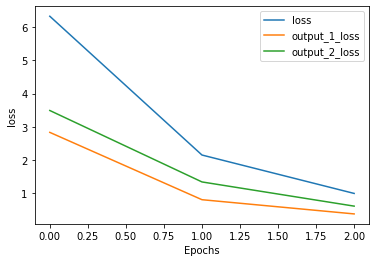

In [22]:
plot_graphs(history, 'loss', 'output_1_loss', 'output_2_loss')

In [36]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      ans_token_idx[0] + tokenizer.encode(sentence) + ans_token_idx[-1], axis=0)

  output = tf.expand_dims(start_probs, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LEN):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, end_probs[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

In [28]:
import re
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [37]:
def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenized_context.decode(
      [i for i in prediction if i < tokenized_context.offsets])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [38]:
predict("민족의 영웅")

NameError: ignored